In [37]:
tbounds = {'420454018001': 625506.0,
 '420454108006': 364623.0,
 '420454007005': 1547672.0,
 
 '420454078023': 397516.0,
 
 '420454028004': 434523.0,
 '420454072011': 604956.0,
 '420454041011': 720345.0,
 
 '420454097011': 495151.0,
 
 '420454069023': 401168.0,
 
 '420454099021': 474575.0,
 '420454038001': 355061.0,
 '420454091002': 605167.0,
 
 '420454103022': 685751.0,
 
 '420454068012': 373176.0,
 '420454050001': 504418.0,
 '420293001042': 908520.0,
 '420293021012': 784436.0,
 '420912058053': 378097.0,
 
 '420912058011': 4538982.0,
 
 '420912049001': 761349.0,
 '420912054005': 544211.0}
 

In [35]:
sum([45.23809523809524,
45.23809523809524,
47.142857142857146,
41.904761904761905,
34.76190476190476,
43.80952380952381,
38.095238095238095,
33.333333333333336,
40.476190476190474,
40.95238095238095,
38.57142857142857,
50.476190476190474,
38.095238095238095,
32.38095238095238,
34.76190476190476,
42.38095238095238,
33.80952380952381,
31.428571428571427,
45.714285714285715,
27.61904761904762,
39.04761904761905])

825.2380952380952

In [39]:
from helpers import make_graph, make_map,cleanup,signed_color
import networkx as nx
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
from random import choice
from termcolor import colored
from copy import deepcopy
import timeit
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from typing import List, Dict

def random_spanning_tree(G):
    T = G.copy()
    rand = np.random.uniform(0, 1, T.size())
    for i, edge in enumerate(T.edges()):
        T.edges[edge]["weight"] = rand[i]
    return nx.minimum_spanning_tree(T)

def redistrict(DATA_DIR, big_loop =1, steps=50, tree_loop=150, coefs = [1,1,1], buffer=0, random=False, enrollment_err=10/11, update_rate=5, multipliers=[126.5,1,300],pictures='map', travel_bounds={}):
    if random: tree_loops = 1
    # dist_dict    -- {block group id: {school:distance from block to school}}
    # school_dict  -- {school's block group id: [ids of block groups assigned to school]}
    # target_ratio -- overall ratio of number of minority students to total population
    dist_dict,school_dict,block_data,G = cleanup(DATA_DIR)
    og_schools = deepcopy(school_dict)
    school_dict_r = {v:k for k,val in school_dict.items() for v in val}
    test_list = school_dict['420454018001']
    og_school_dict_r = deepcopy(school_dict_r )
    schoollist = school_dict.keys()
    tot_mino = block_data["MINO"].sum()
    tot_pop = block_data['HS_POP'].sum()
    target_ratio = tot_mino/tot_pop
    coef_sum = sum(coefs)
    mino_coef,trav_coef,comp_coef = (multipliers[i]*coefs[i]/coef_sum for i in coefs)
    # score calculations (compactness is not implemented yet)
    def _calc_score(sch, district):
        trav_score = sum([max([dist_dict[x][sch]-buffer, 0]) *
                      block_data['HS_POP'].loc[x] for x in district])
        return (0, trav_score)
    district_scores = {dist: _calc_score(dist, school_dict[dist]) for dist in schoollist}
    current_dem_score = np.round(sum([district_scores[u][0] for u in schoollist])/tot_pop,3)
    current_trav_score = np.round(sum([district_scores[u][1] for u in schoollist])/tot_pop,3)
    start = timeit.default_timer()
    stop = timeit.default_timer()

    score_list,animation_list = [],[]
    frames = 0
    # improvements is equivilent to steps, it counts the number of times we beat the current score (when we don't beat the score, the map doesn't change (assuming random == False))
    improvements = 0
    def random_condition(score_1, score_2, school1, school2, bound_dict):
        if bound_dict[school1]+ bound_dict[school2] > score_1[1]+ score_2[1]:
            return True
        else:
            return False
    dem_score = 0
    for district in school_dict.values():
        pop = block_data['HS_POP'].loc[district].sum()
        mino = block_data['MINO'].loc[district].sum()
        dem_score += (abs((mino/pop) - target_ratio))**2*pop*100
    dem_score = np.round(dem_score/tot_pop,3)
    print(dem_score)
            
    import pickle
    def pickle_save(obj, path):
        with open(path, "wb") as f:
            return pickle.dump(obj, f)
    scores = []
    from tqdm.notebook import tqdm
    for loop in tqdm(range(big_loop)):
        school_dict = deepcopy(og_schools)
        school_dict_r = deepcopy(og_school_dict_r)
        assert school_dict['420454018001'] == test_list
        improvements = 0
        for step in range(10000):
            if improvements >= steps: break
            # picking a random pair of neighboring districts
            # we pick a random edge of the quotient graph which has a node for each district and an edge if they are adj.
            # this is likely inefficient :)
            schl1 = choice(list(school_dict))
            neighbour_blocks = []
            for i in school_dict[schl1]:
                for block in G.neighbors(i):
                    if block not in school_dict[schl1]:
                        neighbour_blocks.append(block)
            # check neighbors
            try:
                block_choice = choice(neighbour_blocks)
            except:
                continue
            schl2 = school_dict_r[block_choice]
            district_pair = school_dict[schl1] + school_dict[schl2]
            # initialize districts and scores to the current partitioning
            best_district_1 = school_dict[schl1]
            best_district_2 = school_dict[schl2]
            # idx_that_you_need_to_change_if_you_add_a_score_like_zoe_did_on_august_10 = 3
#             best_score = district_scores[schl1][3] + district_scores[schl2][3]
            subgraph_copy = nx.subgraph(G, district_pair).copy()
            # counts the number of times we pick a tree without a good breaking (mostly for debugging)
            no_break = 0
            # Have we gotten a better score?
            improved = False
            # assigns random weights to edges then picks minimum tree this is a random spanning tree (hopefully)
            for tree_iters in range(tree_loop):
                T = random_spanning_tree(subgraph_copy)
                # get the shortest path between schools, we will cut one of these edges
                school_path = list(nx.all_simple_paths(T, source=schl1, target=schl2))[0]
                # trash all the school_path edges and collect the connected components
                # then we can go from one side of the path to the other and see which split gives balanced population

                T.remove_edges_from(nx.utils.pairwise(school_path))
                comps = [list(nx.node_connected_component(T, i))
                         for i in school_path]
                split_pop = block_data['HS_POP'].loc[comps[0]].sum()
                first_enroll = block_data['enrollment'].loc[schl1]
                second_enroll = block_data['enrollment'].loc[schl2]
                pair_pop = block_data['HS_POP'].loc[district_pair].sum()
                # check enrollment capacities
                for i in range(len(school_path)):
                    # if we get past max. enrollment without a valid split, the tree cannot be broken
                    if split_pop*enrollment_err > first_enroll:
                        split = 0
                        break
                    if (pair_pop - split_pop)*enrollment_err < second_enroll:
                        split = i+1
                        break
                    # add the population of the next component in the path
                    split_pop += block_data['HS_POP'].loc[comps[i+1]].sum()
                if split == 0 or split == len(school_path):
                    no_break += 1
                    continue
                # we have a split, now we make districts and check scores
                district_1 = [y for x in [comps[i]
                                          for i in range(split)] for y in x]
                district_2 = [x for x in district_pair if x not in district_1]
                if (not district_1) or (not district_2):
                    continue
                scores1 = _calc_score(schl1, district_1)
                scores2 = _calc_score(schl2, district_2)
                # when random argument is True we don'toptimize score

                if random_condition(scores1, scores2, schl1, schl2, travel_bounds):
                    improved = True
                    all_scores = (scores1,scores2)
                    best_district_1 = district_1
                    best_district_2 = district_2

            frames += 1
            # if score decreased, we edit the current districting
            if improved:
                improvements += 1
                district_scores[schl1] = all_scores[0]
                district_scores[schl2] = all_scores[1]
                school_dict[schl1] = best_district_1
                school_dict[schl2] = best_district_2
                for block in best_district_1:
                    school_dict_r[block] = schl1
                for block in best_district_2:
                    school_dict_r[block] = schl2
        print(np.round(sum([district_scores[u][1] for u in schoollist])/tot_pop,3))
        dem_score = 0
        for district in school_dict.values():
            pop = block_data['HS_POP'].loc[district].sum()
            mino = block_data['MINO'].loc[district].sum()
            dem_score += (abs((mino/pop) - target_ratio))**2*pop*100
        dem_score = np.round(dem_score/tot_pop,3)
        scores.append(dem_score)
        if loop%1 == 0:
            pickle_save(scores,f'upper_bound_results.pkl')
    return scores


# results = redistrict(data_dir,big_loop=2,steps=100,tree_loop=1,coefs=[5,3,1],random=False)
# pickle_save(results,'paper_stuff.pkl')
data_dir = '/Users/zoeshleifer/Gerrymandering2-promys2020/gerry_tree'
results = redistrict(data_dir,big_loop= 5000, steps=300,tree_loop=1,random=True,pictures='map',travel_bounds = tbounds)


3.562


444.788
448.235
453.335
443.293
459.944
455.688
453.154
444.212
454.903
441.989
451.726
444.614
443.512
442.727
473.165
437.181



KeyboardInterrupt: 

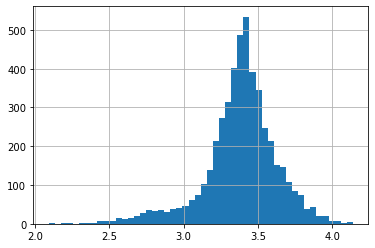

In [9]:
avocado = pd.Series((pd.read_pickle('upper_bound_results1.pkl')))
avocado.hist(bins=50)

3.402


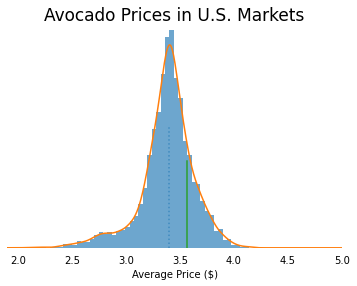

In [40]:

fig, ax = plt.subplots(figsize = (6,4))

# Plot
    # Plot histogram
avocado.plot(kind = "hist", density = True, alpha = 0.65, bins = 50) # change density to true, because KDE uses density
    # Plot KDE
avocado.plot(kind = "kde")

    # Quantile lines
quant_95 = avocado.quantile(0.50)
print(quant_95)
quants = [[quant_95, 0.6, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")


# X
ax.set_xlabel("Average Price ($)")
    # Limit x range to 0-4
x_start, x_end = 1.9, 5
ax.set_xlim(x_start, x_end)

# Y
ax.set_ylim(0, 2.5)
ax.set_yticklabels([])
ax.set_ylabel("")


# Overall
ax.grid(False)
ax.set_title("Avocado Prices in U.S. Markets", size = 17, pad = 10)

    # Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
plt.plot((3.562,3.562),(0,1),label='Original Districting')    
plt.show()